In [1]:
import networkx as nx
import numpy as np
import pickle
import locale
import numpy as np
import os
import powerlaw
import matplotlib.pyplot as plt
import warnings
import random

from scipy.stats.stats import pearsonr

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [3]:
pd.set_option('display.float_format', 
              lambda x: locale.format('%.0f', x, grouping=True) if abs(x)>1000 else locale.format('%.2f', x))

Load graphs and deegrees:

In [4]:
%run 'create-final-graphs.ipynb'

## Correlations between degree distributions

Calculate degree distribution correlations between every USF network and corresponding synthetic networks:

In [5]:
dist1_udir = np.unique(degrees['USF_undirected'], return_counts=True)
dist1_dir = np.unique(degrees['USF_directed'], return_counts=True)

for lab in sorted(filter(lambda x: 'USF' not in x, degrees.keys())):
    if 'cs' in lab or 'knn' in lab:
        source  = 'dir'
        dist1 = dist1_dir
    else:
        source = 'udir'
        dist1 = dist1_udir

    dist2 = np.unique(degrees[lab], return_counts=True)

    x = np.zeros(max(max(dist1[0]), max(dist2[0])))
    y = np.zeros(len(x))

    x[dist1[0]-1] = dist1[1]  # populate node-degrees with degree counts
    y[dist2[0]-1] = dist2[1]
    y_rnd = sorted(y, key=lambda k: random.random())
    
    print(source, lab, "r=%.2f, p=%.3f"%pearsonr(x, y), '[random: r=%.2f, p=%.3f]'%pearsonr(x, y_rnd))

udir glove-cos r=0.49, p=0.000 [random: r=0.01, p=0.825]
dir glove-cs-cos r=0.88, p=0.000 [random: r=0.11, p=0.040]
dir glove-cs-dot r=0.93, p=0.000 [random: r=0.09, p=0.123]
udir glove-dot r=0.46, p=0.000 [random: r=-0.02, p=0.672]
dir glove-knn-cos r=0.83, p=0.000 [random: r=-0.01, p=0.812]
dir glove-knn-dot r=0.92, p=0.000 [random: r=-0.04, p=0.515]
dir w2v-cs-cos r=0.75, p=0.000 [random: r=-0.04, p=0.469]
dir w2v-cs-dot r=0.91, p=0.000 [random: r=0.17, p=0.002]
dir w2v-knn-cos r=0.69, p=0.000 [random: r=-0.02, p=0.668]
dir w2v-knn-dot r=0.87, p=0.000 [random: r=-0.05, p=0.335]
udir word2vec-cos r=0.74, p=0.000 [random: r=-0.06, p=0.267]
udir word2vec-dot r=0.39, p=0.000 [random: r=-0.01, p=0.821]


Load goodness-of-fit test results evaluating plausibility of power-law:

In [6]:
gof_results = pd.read_csv('../semnet_compare/results/gof_test.csv', header=None, index_col=0, names=['pval'])

In [7]:
warnings.simplefilter("ignore", RuntimeWarning)  # silence powerlaw warnings

comparisons = [
    ('power_law', 'truncated_power_law'),
    ('power_law', 'lognormal'),
    ('power_law', 'exponential'),
    ('truncated_power_law', 'lognormal'),
    ('truncated_power_law', 'exponential'),
    ('lognormal', 'exponential')]

columns = ['KS', 'p', 'R', 'p', 'R', 'p', 'R', 'p']
labels = ['USF_undirected', 'glove-cos', 'word2vec-cos', 'USF_directed','glove-cs-cos', 
          'glove-knn-cos', 'w2v-cs-cos', 'w2v-knn-cos']

df = pd.DataFrame(columns=columns, index=labels)

In [8]:
for i, label in enumerate(labels):
    print('Tests for:', label)
    print('---')
    deg = degrees[label]
    row = []
    results = powerlaw.Fit(deg, discrete=True)
    row.extend([results.power_law.KS(), gof_results.pval[label]])
    
    for dist1, dist2 in comparisons:
        R, p = results.distribution_compare(dist1, dist2, normalized_ratio=True)
        print(dist1, 'vs', dist2, "R=%.2f, p=%.3f"%(R, p))
        if dist1=='power_law':
            row.extend([R, p])

    # just for info
    s = "x_min=%.2f, alpha=%.2f, ks(plaw)=%.3f, ks(trunc)=%.3f"%(
        results.xmin, results.alpha, results.power_law.KS(), results.truncated_power_law.KS())        
    print(s)
    
    df.loc[label] = row
    print()

Tests for: USF_undirected
---


Calculating best minimal value for power law fit
Assuming nested distributions


power_law vs truncated_power_law R=-1.80, p=0.018
power_law vs lognormal R=-0.91, p=0.365
power_law vs exponential R=7.46, p=0.000
truncated_power_law vs lognormal R=3.00, p=0.003
truncated_power_law vs exponential R=7.93, p=0.000
lognormal vs exponential R=7.74, p=0.000
x_min=19.00, alpha=3.08, ks(plaw)=0.014, ks(trunc)=0.028

Tests for: glove-cos
---


Calculating best minimal value for power law fit
Assuming nested distributions


power_law vs truncated_power_law R=-7.29, p=0.000
power_law vs lognormal R=-5.03, p=0.000
power_law vs exponential R=7.82, p=0.000
truncated_power_law vs lognormal R=9.66, p=0.000
truncated_power_law vs exponential R=12.01, p=0.000
lognormal vs exponential R=11.08, p=0.000
x_min=15.00, alpha=2.09, ks(plaw)=0.035, ks(trunc)=0.033

Tests for: word2vec-cos
---


Calculating best minimal value for power law fit
Assuming nested distributions


power_law vs truncated_power_law R=-7.72, p=0.000
power_law vs lognormal R=-5.31, p=0.000
power_law vs exponential R=-5.89, p=0.000
truncated_power_law vs lognormal R=0.74, p=0.461
truncated_power_law vs exponential R=-1.34, p=0.180
lognormal vs exponential R=-5.27, p=0.000
x_min=40.00, alpha=3.21, ks(plaw)=0.064, ks(trunc)=0.031

Tests for: USF_directed
---


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Assuming nested distributions


power_law vs truncated_power_law R=-2.54, p=0.000
power_law vs lognormal R=-2.36, p=0.018
power_law vs exponential R=0.27, p=0.785
truncated_power_law vs lognormal R=0.43, p=0.667
truncated_power_law vs exponential R=1.98, p=0.048
lognormal vs exponential R=1.95, p=0.052
x_min=37.00, alpha=2.93, ks(plaw)=0.055, ks(trunc)=0.014

Tests for: glove-cs-cos
---


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Assuming nested distributions


power_law vs truncated_power_law R=-1.33, p=0.100
power_law vs lognormal R=-0.88, p=0.381
power_law vs exponential R=2.61, p=0.009
truncated_power_law vs lognormal R=2.62, p=0.009
truncated_power_law vs exponential R=3.30, p=0.001
lognormal vs exponential R=3.14, p=0.002
x_min=26.00, alpha=3.70, ks(plaw)=0.018, ks(trunc)=0.029

Tests for: glove-knn-cos
---


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Assuming nested distributions


power_law vs truncated_power_law R=-1.05, p=0.158
power_law vs lognormal R=-0.82, p=0.409
power_law vs exponential R=1.08, p=0.279
truncated_power_law vs lognormal R=1.93, p=0.054
truncated_power_law vs exponential R=1.78, p=0.075
lognormal vs exponential R=1.67, p=0.096
x_min=29.00, alpha=4.73, ks(plaw)=0.020, ks(trunc)=0.030

Tests for: w2v-cs-cos
---


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Assuming nested distributions


power_law vs truncated_power_law R=-0.03, p=0.966
power_law vs lognormal R=0.02, p=0.984
power_law vs exponential R=1.13, p=0.257
truncated_power_law vs lognormal R=0.11, p=0.916
truncated_power_law vs exponential R=1.15, p=0.251
lognormal vs exponential R=1.14, p=0.254
x_min=36.00, alpha=6.19, ks(plaw)=0.035, ks(trunc)=0.037

Tests for: w2v-knn-cos
---


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Assuming nested distributions


power_law vs truncated_power_law R=-0.13, p=0.824
power_law vs lognormal R=-0.12, p=0.903
power_law vs exponential R=0.69, p=0.488
truncated_power_law vs lognormal R=0.00, p=1.000
truncated_power_law vs exponential R=0.77, p=0.440
lognormal vs exponential R=0.78, p=0.437
x_min=31.00, alpha=7.10, ks(plaw)=0.028, ks(trunc)=0.028



In [9]:
x = df.copy()

x.index = pd.Index(map(lambda y: y if 'USF' in y else y[:y.find('-cos')], x.index))

x.columns = pd.MultiIndex.from_product([['Power Law', 
                                         '\thead{Power Law vs.\\\Truncated Power Law}', 
                                         '\thead{Power Law vs.\\\Lognormal}', 
                                         '\thead{Power Law vs.\\\Exponential}'], ['LR', '$p$']])
x[x.columns[0]] = x[x.columns[0]].map(lambda x: '%.3f' % x)
x

Power Law      \thead{Power Law vs.\\Truncated Power Law}       \
                      LR  $p$                                         LR  $p$   
USF_undirected     0.014 0.01                                      -1.80 0.02   
glove              0.035 0.00                                      -7.29 0.00   
word2vec           0.064 0.00                                      -7.72 0.00   
USF_directed       0.055 0.00                                      -2.54 0.00   
glove-cs           0.018 0.00                                      -1.33 0.10   
glove-knn          0.020 0.00                                      -1.05 0.16   
w2v-cs             0.035 0.00                                      -0.03 0.97   
w2v-knn            0.028 0.00                                      -0.13 0.82   

               \thead{Power Law vs.\\Lognormal}       \
                                             LR  $p$   
USF_undirected                            -0.91 0.37   
glove                                     -5.03 0.00   
word2vec                                  -5.31 0.00   
USF_directed                              -2.36 0.02   
glove-cs                                  -0.88 0.38   
glove-knn                                 -0.82 0.41   
w2v-cs                                     0.02 0.98   
w2v-knn                                   -0.12 0.90   

               \thead{Power Law vs.\\Exponential}       
                                               LR  $p$  
USF_undirected                               7.46 0.00  
glove                                        7.82 0.00  
word2vec                                    -5.89 0.00  
USF_directed                                 0.27 0.79  
glove-cs                                     2.61 0.01  
glove-knn                                    1.08 0.28  
w2v-cs                                       1.13 0.26  
w2v-knn                                      0.69 0.49

## Plotting distributions

Note: the fits plotted below are shifted up. This happens as the `plot_ccdf` function in the `powerlaw` package plots fits starting with the CDF value of 1, which for those fits was at $k_{min}$ (the first datapoint for which the fit was performed). For more details on what is going on here, see [this](https://github.com/jeffalstott/powerlaw/issues/41) discussion on GitHub.

I have implemented the shift in my local installation of the `powerlaw` package, based on an [unmerged fork](https://github.com/psinger/powerlaw/commit/7dab5e2fd7fe6d7a64d08311bf19b3f853a08581), but it is not practical to put it here. That fork is from an outdated version of `networkx` so it can't be used directly. If I find a better solution, I will update these instructions.

In that implementation, the parameter `shift_by="original_data"` positions the fits as in the paper.

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


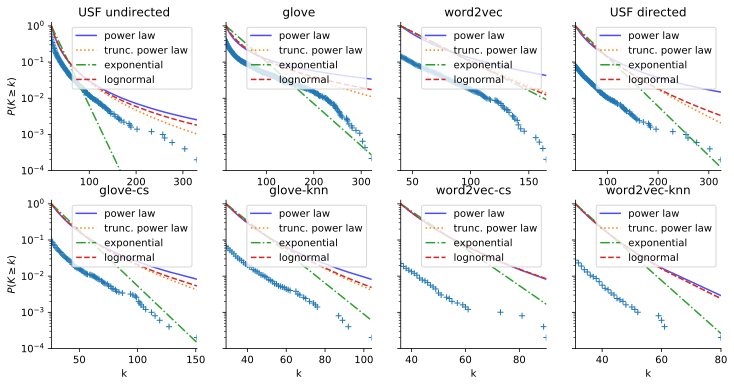

In [10]:
plt.figure(figsize=(12, 6))

# dictate order
graph_labels = labels

nr_rows, nr_cols = 2, 4
for i, lab in enumerate(graph_labels):
    ax = plt.subplot(nr_rows, nr_cols, i+1)
    title = lab
    if 'cos' in lab:
        title = lab[:lab.find('cos')-1]
    title = title.replace('_', ' ').replace('w2v', 'word2vec')
    plt.title(title)
    
    results = powerlaw.Fit(degrees[lab], discrete=True)
    xmin, alpha = int(results.power_law.xmin), results.power_law.alpha
    
    bins, data = powerlaw.cdf(degrees[lab], survival=True)
    plt.plot(bins, data, '+')
    
    ax = plt.gca()
    results.power_law.plot_ccdf(ax=ax, color='b',ls='-', label='power law', alpha=0.7)
    results.truncated_power_law.plot_ccdf(ax=ax, ls=':', label='trunc. power law')
    results.exponential.plot_ccdf(ax=ax,  ls='-.', label='exponential')
    results.lognormal.plot_ccdf(ax=ax,  ls='--',label='lognormal')

    plt.ylim(10**-4, 10**0.1)
    plt.xlim(xmin, max(bins))
    plt.legend(loc='upper right')
    sns.despine()
    plt.xscale('linear'); 
    plt.yscale('log')
    
    if i < nr_cols:
        ax.set_xlabel('')
    else:
        ax.set_xlabel('k')
    if i!=0 and i!=nr_cols:
        ax.yaxis.set_ticklabels([])
        ax.set_ylabel('')
    else:
        ax.set_ylabel('$P(K\geq k)$')

plt.show()